# Experiment 4:
## U-Net: Prediction of Human Pose Masks & Softmax Joint Classes & Regression Values

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1";  

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np 
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.preprocessing import image
import cv2
from keras.utils import multi_gpu_model
from scipy import ndimage
from keras.utils import to_categorical
from keras.models import load_model
from keras import losses
from keras import backend as K 

Using TensorFlow backend.


## Create Training and Validation Sets

In [3]:
image_adr = 'SMALL_5K_IMAGES/'
mask_adr = 'SMALL_5K_MASKS/'
heatmap_adr = 'SMALL_5K_HEATMAPSOFTMAX/'
regression_adr = 'SMALL_5K_HEATMAPS/'

#image_adr = 'BIG_18K_IMAGES/'
#mask_adr = 'BIG_18K_MASKS/'

images = sorted(os.listdir(image_adr))
masked = sorted(os.listdir(mask_adr))
heatmaps = sorted(os.listdir(heatmap_adr))

In [4]:
print(len(images))
print(len(masked))

5000
5000


In [5]:
np.random.seed(23)
order = np.random.permutation(len(images))
X_train = order[:int(0.8*len(order))]
X_valid = order[int(0.8*len(order)):]
print(len(X_train))
print(len(X_valid))

4000
1000


***

## U-Net Model

In [6]:
smooth = 1e-6

def pixelwise_mse(y_pred, y_true):
    y_pred = K.flatten(y_pred[0,:,:,0])
    y_true = K.flatten(y_true[0,:,:,0])
    return losses.mean_squared_error(y_pred, y_true)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true[0,:,:,1])
    y_pred_f = K.flatten(y_pred[0,:,:,1])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def dice_coef_hard(y_pred, y_true):
    y_true_f = K.flatten(y_true[0,:,:,1])
    y_pred_f = K.flatten(np.argmax(y_pred[0,:,:,:], axis=-1).astype('float32'))
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

In [7]:
def create_unet(min_neuron):
    
    inputs = Input((None, None, 3))
    
    conv1 = Conv2D(min_neuron, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(min_neuron, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(min_neuron*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(min_neuron*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    drop2 = Dropout(0.3)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)
    
    conv3 = Conv2D(min_neuron*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(min_neuron*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.3)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)
    
    conv4 = Conv2D(min_neuron*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(min_neuron*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.3)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(min_neuron*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(min_neuron*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.3)(conv5)

    up6 = Conv2D(min_neuron*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(min_neuron*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(min_neuron*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    drop6 = Dropout(0.3)(conv6)
    
    up7 = Conv2D(min_neuron*4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(min_neuron*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(min_neuron*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    drop7 = Dropout(0.3)(conv7)

    up8 = Conv2D(min_neuron*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(min_neuron*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(min_neuron*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    drop8 = Dropout(0.3)(conv8)

    up9 = Conv2D(min_neuron, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(min_neuron, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(min_neuron, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    mask_out = Conv2D(2, 1, activation='softmax', name='output1')(conv9)
    heatmap_out = Conv2D(26, 1, activation='softmax', name='output2')(conv9)   # For HeatMaps
    regression_out = Conv2D(1, 1, activation='linear', name='output3')(conv9)
    
    model = Model(inputs=inputs, outputs=[mask_out, heatmap_out, regression_out])    
    model.compile(optimizer = Adam(lr=2e-5), loss={'output1': dice_loss, 'output2': 'categorical_crossentropy', 'output3': pixelwise_mse}, metrics={'output1': dice_coef})

    return model

In [8]:
def generator(X_data, y_data, order):
    
    samples_per_epoch = len(order)
    number_of_batches = samples_per_epoch
    
    counter=0
    
    while 1:
        
        X_batch = cv2.cvtColor(cv2.imread(image_adr + X_data[order[counter]]), cv2.COLOR_BGR2RGB).astype('float32')
        X_batch /= 255
        
        r = X_batch.shape[0]
        c = X_batch.shape[1]
        r_pad = 0
        c_pad = 0
        
        while r % 16 != 0:
            r_pad += 1
            r += 1
            
        while c % 16 != 0:
            c_pad += 1
            c += 1
            
        X_batch = np.pad(X_batch, ((0, r_pad), (0, c_pad), (0, 0)), mode='constant', constant_values=0)
        X_batch = np.expand_dims(X_batch, axis=0)

        y_heatmap = np.load(heatmap_adr + heatmaps[order[counter]])  # For Heatmaps
        y_heatmap = np.pad(y_heatmap, ((0, r_pad), (0, c_pad)), mode='constant', constant_values=0)
        y_map = np.zeros(y_heatmap.shape + (26,))
        
        for i in range(26):
            y_map[(y_heatmap == i), i] = 1
        
        y_map = np.expand_dims(y_map, 0)
        
        y_mask = (cv2.imread(mask_adr + y_data[order[counter]], 0) > 200).astype('float32') # For Mask
        y_mask = np.pad(y_mask, ((0, r_pad), (0, c_pad)), mode='constant', constant_values=0)
        y_mask = to_categorical(y_mask, 2) # For Mask
        y_mask = np.expand_dims(y_mask, 0)
        
        y_batch = cv2.imread(regression_adr + y_data[order[counter]], 0).astype('float32')/255*100  # For Heatmaps
        #y_batch = (cv2.imread(mask_adr + y_data[order[counter]], 0) > 200).astype('float32') # For Mask
        y_batch = np.pad(y_batch, ((0, r_pad), (0, c_pad)), mode='constant', constant_values=0)
        
        #y_batch = to_categorical(y_batch, 2) # For Mask
        y_batch = np.expand_dims(y_batch, -1) # For Heatmap
        y_batch = np.expand_dims(y_batch, 0)

        counter += 1
        
        yield X_batch, {'output1': y_mask, 'output2': y_map, 'output3': y_batch}

        #restart counter to yeild data in the next epoch as well
        if counter >= number_of_batches:
            counter = 0

In [9]:
model1 = create_unet(64)
model1.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 6 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxP

***

## Model Training

### Small Dataset Training

In [10]:
checkpoint = ModelCheckpoint('model-{epoch:03d}-{val_loss:03f}.h5', verbose=1, 
                             monitor='val_loss', save_best_only=True, mode='auto') 


history = model1.fit_generator(generator(images, masked, X_train),
                              epochs=100,
                              steps_per_epoch = len(X_train),
                              validation_data = generator(images, masked, X_valid),
                              validation_steps = len(X_valid),
                              callbacks=[checkpoint])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100
4000/4000 [==============================] - 278s 70ms/step - loss: 20.2492 - output1_loss: 0.2862 - output2_loss: 0.1906 - output3_loss: 19.7724 - output1_dice_coef: 0.7138 - val_loss: 19.7129 - val_output1_loss: 0.2350 - val_output2_loss: 0.1985 - val_output3_loss: 19.2794 - val_output1_dice_coef: 0.7650

Epoch 00001: val_loss improved from inf to 19.71295, saving model to model-001-19.712949.h5
Epoch 2/100
4000/4000 [==============================] - 267s 67ms/step - loss: 18.7047 - output1_loss: 0.1824 - output2_loss: 0.1316 - output3_loss: 18.3907 - output1_dice_coef: 0.8176 - val_loss: 18.8456 - val_output1_loss: 0.1893 - val_output2_loss: 0.1634 - val_output3_loss: 18.4929 - val_output1_dice_coef: 0.8107

Epoch 00002: val_loss improved from 19.71295 to 18.84558, saving model to model-002-18.845585.h5
Epoch 3/100
4000/4000 [====================


Epoch 00019: val_loss did not improve from 14.93886
Epoch 20/100
4000/4000 [==============================] - 267s 67ms/step - loss: 11.3281 - output1_loss: 0.1003 - output2_loss: 0.0734 - output3_loss: 11.1544 - output1_dice_coef: 0.8997 - val_loss: 15.0410 - val_output1_loss: 0.1126 - val_output2_loss: 0.0837 - val_output3_loss: 14.8446 - val_output1_dice_coef: 0.8874

Epoch 00020: val_loss did not improve from 14.93886
Epoch 21/100
4000/4000 [==============================] - 267s 67ms/step - loss: 11.0597 - output1_loss: 0.0992 - output2_loss: 0.0724 - output3_loss: 10.8881 - output1_dice_coef: 0.9008 - val_loss: 15.0270 - val_output1_loss: 0.1111 - val_output2_loss: 0.0840 - val_output3_loss: 14.8319 - val_output1_dice_coef: 0.8889

Epoch 00021: val_loss did not improve from 14.93886
Epoch 22/100
4000/4000 [==============================] - 267s 67ms/step - loss: 10.8535 - output1_loss: 0.0985 - output2_loss: 0.0713 - output3_loss: 10.6837 - output1_dice_coef: 0.9015 - val_loss: 


Epoch 00041: val_loss did not improve from 14.93886
Epoch 42/100
4000/4000 [==============================] - 267s 67ms/step - loss: 7.3476 - output1_loss: 0.0907 - output2_loss: 0.0583 - output3_loss: 7.1986 - output1_dice_coef: 0.9093 - val_loss: 15.4818 - val_output1_loss: 0.1055 - val_output2_loss: 0.0821 - val_output3_loss: 15.2942 - val_output1_dice_coef: 0.8945

Epoch 00042: val_loss did not improve from 14.93886
Epoch 43/100
4000/4000 [==============================] - 267s 67ms/step - loss: 7.1870 - output1_loss: 0.0909 - output2_loss: 0.0577 - output3_loss: 7.0384 - output1_dice_coef: 0.9091 - val_loss: 15.5196 - val_output1_loss: 0.1048 - val_output2_loss: 0.0832 - val_output3_loss: 15.3316 - val_output1_dice_coef: 0.8952

Epoch 00043: val_loss did not improve from 14.93886
Epoch 44/100
4000/4000 [==============================] - 267s 67ms/step - loss: 7.1033 - output1_loss: 0.0899 - output2_loss: 0.0572 - output3_loss: 6.9562 - output1_dice_coef: 0.9101 - val_loss: 15.524

4000/4000 [==============================] - 267s 67ms/step - loss: 5.1614 - output1_loss: 0.0858 - output2_loss: 0.0504 - output3_loss: 5.0252 - output1_dice_coef: 0.9142 - val_loss: 15.8020 - val_output1_loss: 0.1039 - val_output2_loss: 0.0853 - val_output3_loss: 15.6128 - val_output1_dice_coef: 0.8961

Epoch 00064: val_loss did not improve from 14.93886
Epoch 65/100
4000/4000 [==============================] - 267s 67ms/step - loss: 5.0611 - output1_loss: 0.0857 - output2_loss: 0.0501 - output3_loss: 4.9253 - output1_dice_coef: 0.9143 - val_loss: 15.7542 - val_output1_loss: 0.1058 - val_output2_loss: 0.0859 - val_output3_loss: 15.5625 - val_output1_dice_coef: 0.8942

Epoch 00065: val_loss did not improve from 14.93886
Epoch 66/100
4000/4000 [==============================] - 267s 67ms/step - loss: 5.0019 - output1_loss: 0.0853 - output2_loss: 0.0498 - output3_loss: 4.8668 - output1_dice_coef: 0.9147 - val_loss: 15.8203 - val_output1_loss: 0.1062 - val_output2_loss: 0.0859 - val_outp

***

## Model Save

In [15]:
#model.save_weights('15ep_softmax_model_BIG.h5')
model1.save('100ep-heatmap-mask-model-val_dice_9221-val_cce_00564.h5')

## Model Load

In [12]:
dependencies = {
    'dice_loss': dice_loss,
    'dice_coef_hard': dice_coef_hard,
    'dice_coef': dice_coef
}

#model = keras.models.load_model('30ep_FULL_model_SMALL.h5', custom_objects=dependencies)
model = load_model('model-089-0.919240-0.080760.h5', custom_objects=dependencies)
#model = load_model('100ep_FULL_dropout_softmax_model_SMALL.h5', custom_objects=dependencies)

***

## Model Performance

### Small Dataset

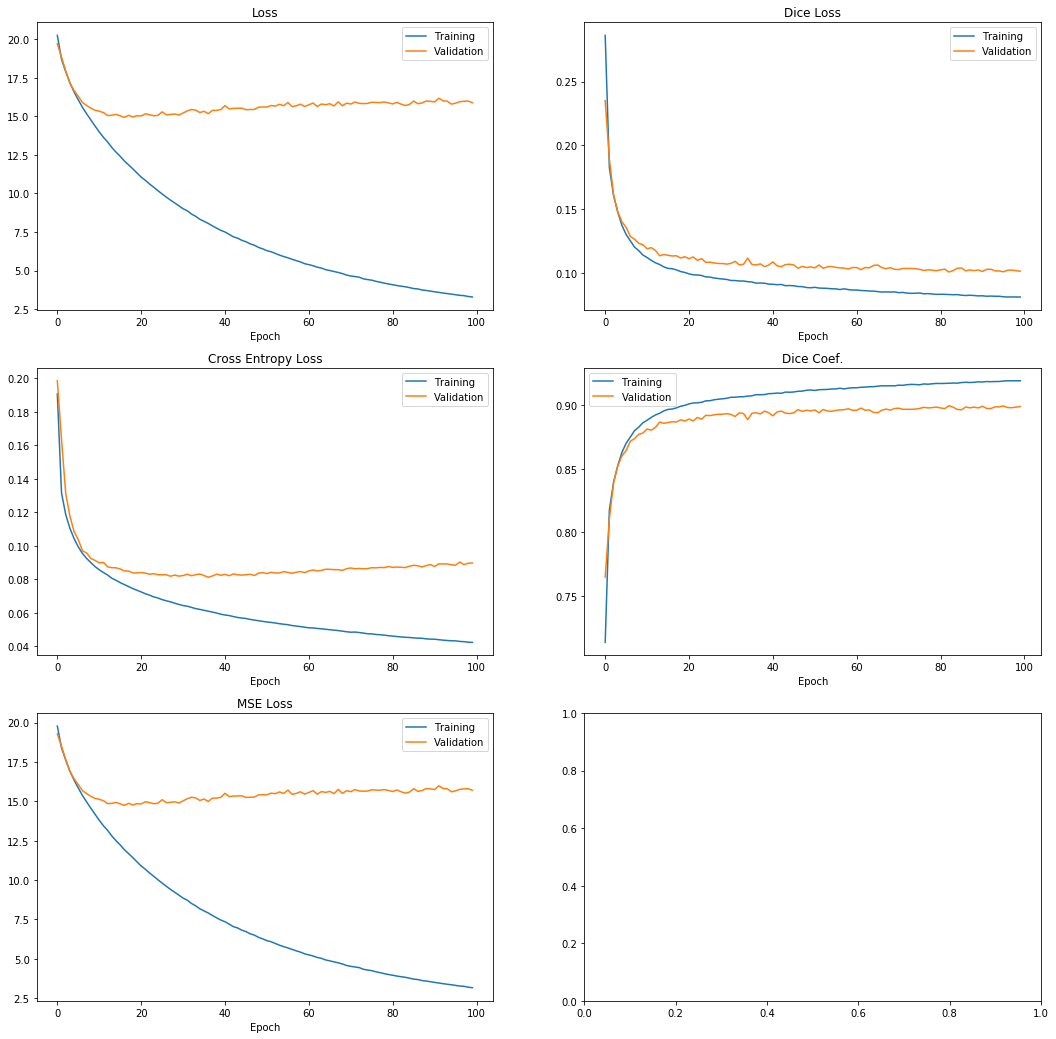

In [17]:
ad = history.history

f, ax = plt.subplots(3,2, figsize=(18,18))

ax[0,0].plot(ad['loss'], label='Training')
ax[0,0].plot(ad['val_loss'], label='Validation')
ax[0,0].set_title('Loss')
ax[0,0].set_xlabel('Epoch')
ax[0,0].legend()

ax[0,1].plot(ad['output1_loss'], label='Training')
ax[0,1].plot(ad['val_output1_loss'], label='Validation')
ax[0,1].set_title('Dice Loss')
ax[0,1].set_xlabel('Epoch')
ax[0,1].legend()

ax[1,0].plot(ad['output2_loss'], label='Training')
ax[1,0].plot(ad['val_output2_loss'], label='Validation')
ax[1,0].set_title('Cross Entropy Loss')
ax[1,0].set_xlabel('Epoch')
ax[1,0].legend()

ax[1,1].plot(ad['output1_dice_coef'], label='Training')
ax[1,1].plot(ad['val_output1_dice_coef'], label='Validation')
ax[1,1].set_title('Dice Coef.')
ax[1,1].set_xlabel('Epoch')
ax[1,1].legend()

ax[2,0].plot(ad['output3_loss'], label='Training')
ax[2,0].plot(ad['val_output3_loss'], label='Validation')
ax[2,0].set_title('MSE Loss')
ax[2,0].set_xlabel('Epoch')
ax[2,0].legend()

***

## Sample Predictions

### Small Dataset

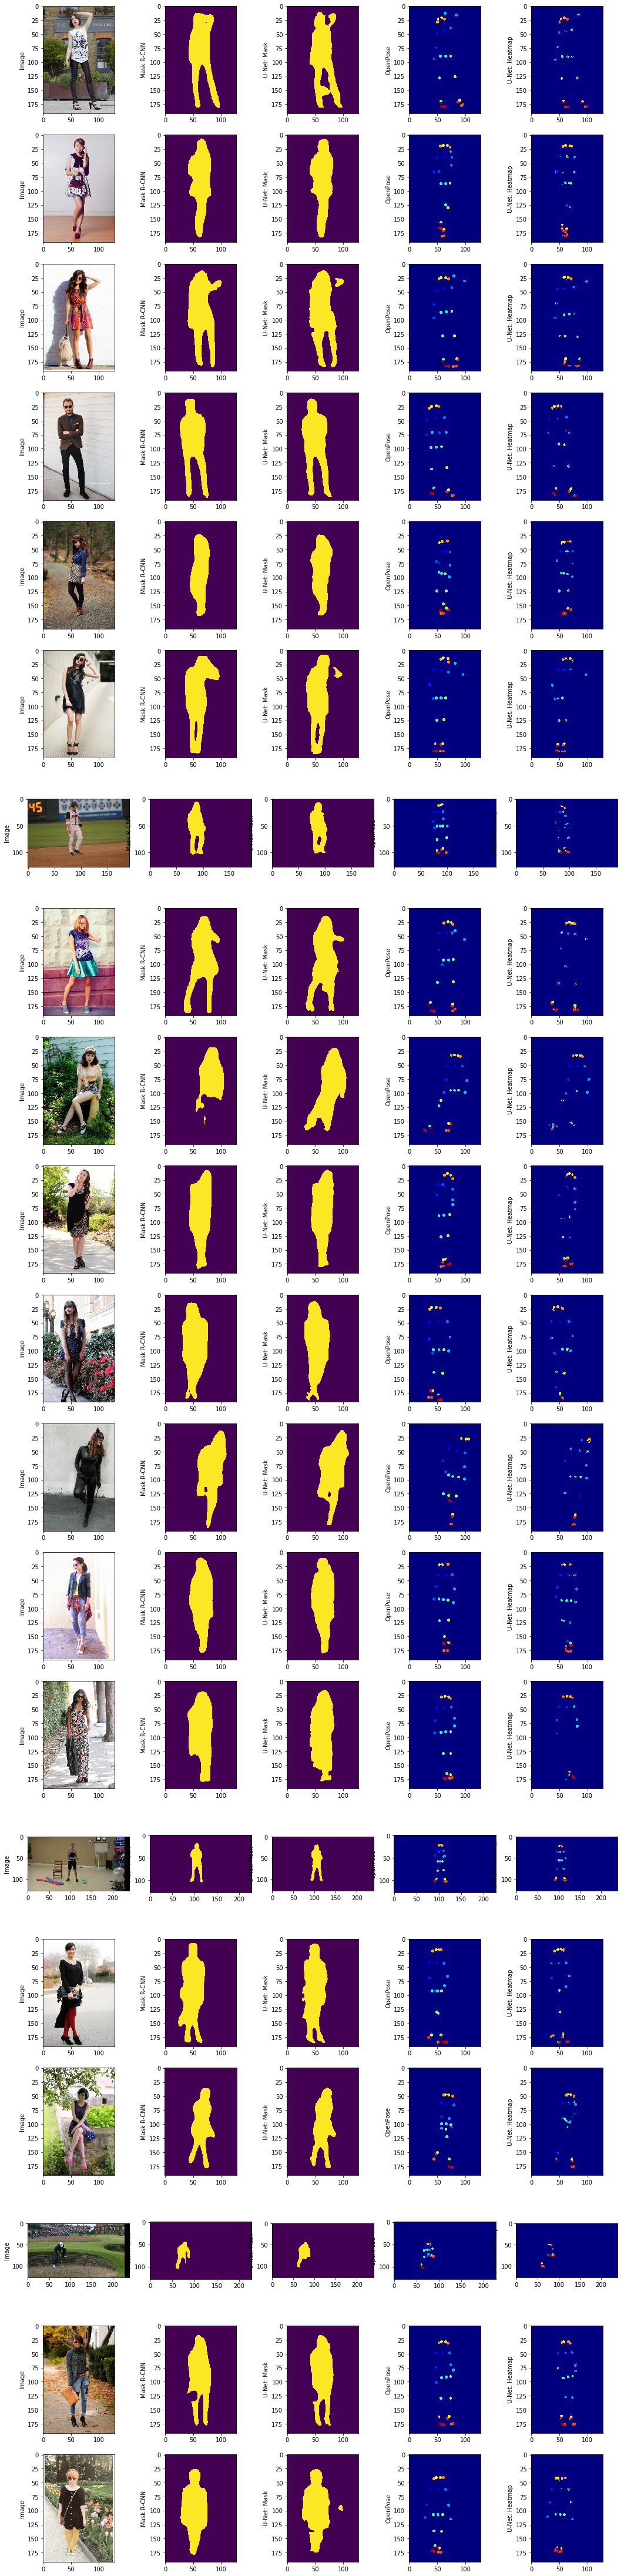

In [18]:
image_list = X_valid[40:60]

f, ax = plt.subplots(20,5, figsize=(18,80))
c_ = 0

for i in range(20):
    X_batch = cv2.cvtColor(cv2.imread(image_adr + images[image_list[c_]]), cv2.COLOR_BGR2RGB).astype('float32')
    X_batch /= 255

    r = X_batch.shape[0]
    c = X_batch.shape[1]
    r_pad = 0
    c_pad = 0

    while r % 16 != 0:
        r_pad += 1
        r += 1

    while c % 16 != 0:
        c_pad += 1
        c += 1

    X_batch = np.pad(X_batch, ((0, r_pad), (0, c_pad), (0, 0)), mode='constant', constant_values=0)
    ax[i,0].imshow(X_batch)
    X_batch = np.expand_dims(X_batch, axis=0)

    pred = model1.predict(X_batch)
    pred_1 = np.argmax(pred[0], axis=3)[0]
    pred_2 = np.argmax(pred[1], axis=3)

    ax[i,1].imshow(cv2.imread(mask_adr + images[image_list[c_]], 0))
    ax[i,2].imshow(pred_1)
    ax[i,3].imshow(np.load('SMALL_5K_HEATMAPSOFTMAX/' + images[image_list[c_]].replace('.jpg', '.npy'), 0), cmap='jet')
    ax[i,4].imshow(np.squeeze(pred_2), cmap='jet')

    c_ += 1

for j in range(20):
    _ = ax[j,0].set_ylabel('Image')
    _ = ax[j,1].set_ylabel('Mask R-CNN')
    _ = ax[j,2].set_ylabel('U-Net: Mask')
    _ = ax[j,3].set_ylabel('OpenPose')
    _ = ax[j,4].set_ylabel('U-Net: Heatmap')